In [49]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

# **Right BST and SCR correlation difference**

**This is an intercept model in which the dependent variable (Y) is the difference (uncon-con) of the SCR-BST correlation coefficient.**

## **Model**

$$Y \sim N(\mu,\sigma^{2}_{\epsilon})$$
$$\mu = \beta_{uncon-con}$$

$Y = z[corr(rBST_{uncon},SCR_{uncon})] - z[corr(rBST_{con},SCR_{con})]$  
*rBST: rBST trial-by-trial (TBT) betas*  
*SCR: skin conductance TBT betas*  

## **Priors**
$$N(0,100): \beta_{uncon-con}$$
$$Cauchy(0,100): \sigma_{\epsilon}$$

In [30]:
library(brms)
library(haven) # to load the SPSS .sav file
library(tidyverse) # needed for data manipulation.
library(RColorBrewer) # needed for some extra colours in one of the graphs
library(ggmcmc)
library(ggthemes)
library(ggridges)

# IMPORT VISUALIZATION LIBRARIES:
library(data.table)
library(ggplot2)
library(ggridges)
library(dplyr)
library(tidyr)
library(scales)
library(viridis)

In [31]:
df <- read.table('data//uncon_v_con_rBNST_SCR_zcorr.txt',header = TRUE)

In [32]:
head(df)

,Pair,ROI,Y
,<fct>,<fct>,<dbl>
1,P00,rBNST,-0.4154
2,P01,rBNST,0.6998
3,P02,rBNST,-0.6481
4,P03,rBNST,-0.4741
5,P04,rBNST,1.1773
6,P05,rBNST,0.0210


In [33]:
colnames(df)

[1] "Pair" "ROI"  "Y"

In [34]:
prior1 <- c(prior(normal(0,100),class=Intercept),
            prior(cauchy(0,100),class=sigma))

In [35]:
bmod1 <- brm(Y ~ 1, 
             data = df, 
             family = gaussian(),
             prior = prior1, 
             warmup = 2000, iter = 5000,
             chains = 4,
             cores  = 2)

Compiling the C++ model

recompiling to avoid crashing R session

Start sampling



In [39]:
summary(bmod1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: Y ~ 1 
   Data: df (Number of observations: 57) 
Samples: 4 chains, each with iter = 5000; warmup = 2000; thin = 1;
         total post-warmup samples = 12000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.21      0.09     0.03     0.38 1.00     9417     7719

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.65      0.06     0.54     0.79 1.00     8964     7455

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [40]:
data <- fixef(bmod1,summary = FALSE)

In [42]:
rois <- colnames(data)

In [44]:
nobj=dim(data)[1]
data_stats = data.frame(1:length(rois))

# create ROI column instead of numerics to match threat table above

data_stats$ROI <- rois
data_stats$mean <- colMeans(data)
data_stats$P <- colSums(data > 0)/nobj
data_stats$Pn <- data_stats$P


for (i in 1:length(rois)) {
  if (data_stats$P[i]<.5){data_stats$Pn[i]=1-data_stats$P[i]}
}


# this will order the distributions correctly
data_stats <- data_stats[order(data_stats$mean),]



data_trans <- as.data.frame(t(as.matrix(data)))
data_trans <- tibble::rownames_to_column(data_trans, "ROI")
data_trans$X <- 1:nrow(data_trans)




# merge values & stats into one table by ROI

data_merge <- merge(data_stats, data_trans, by = "ROI")
data_merge <- data_merge[order(data_merge$X),]

# Transform data into long form


# Melt dataframe by ROI
library(data.table)

data_long <- melt(data_trans, id=c("ROI","X"))

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”


In [45]:
data_long <- data_long[order(data_long$X),]


# This is incredibly clunky, but for the sake of time adding stats by ensuring orders are all the same and repeating each value 2000 times... Tried a few different methods with no success for some reason. 

data_long$mean <- rep(data_merge$mean, each = nobj)
data_long$P <- rep(data_merge$P, each =nobj)
data_long$Pn <- rep(data_merge$Pn, each =nobj)

Picking joint bandwidth of 0.0121

Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


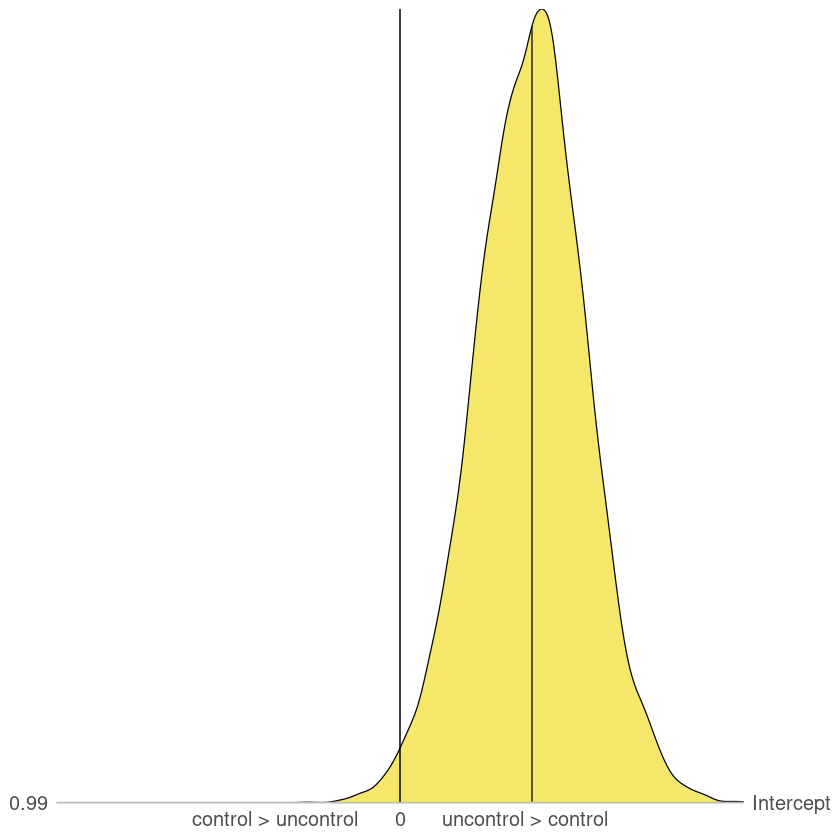

In [47]:
# set your labels here so you don't have to change within the plot below: 
format(round(1, 2), nsmall = 2)

y.axis.labs <- format(round(data_stats$P,2), nsmall = 2)                        # y axis labels
sec.y.axis.labs <- data_stats$ROI                             # second y axis labels (probabilities)


 # X AXIS LABELS NEED TO CHANGE TO CORRESPOND TO DATA SET! UNCOMMENT WHICHEVER MATCHES

# Uncomment for THREAT
x.axis.labs <- c( "control > uncontrol", "0", "uncontrol > control")                 # x axis labels  THREAT
x.labs.pos <- c(-0.2, 0, 0.2)                                             # x axis position THREAT


# Uncomment for VALENCE
#x.axis.labs <- c("Neutral > Positive", "0", "Positive > Neutral")         # x axis labels  VALENCE
#x.labs.pos  <- c(-0.1,0,0.2)                                              # x axis position VALENCE

# Uncomment for INTERACTION
#x.axis.labs <- NULL                                                       # x axis labels  INTERACTION, not sure what to put.
#x.labs.pos <- NULL                                                        # a axis position INTERACTION, change when labels decided

#graph.title <- data.name                                   # graph title 
legend.title <- "Probability"                              # legend title
y.axis.title <- NULL                                       # for now ...
x.axis.title <- NULL                                       # for now...

# GRAPH DATA 
dataset <- data_long
x.values <- data_long$value                               # x values
y.values <- data_long$ROI                                 # y values
y.values.RO <- data_long$value                            # values to reorder Y by
distrib.fill <- data_long$Pn                              # fill graph with probabilities
group <- data_long$ROI

# Other aspects
gradient.colors <- c("yellow","#C9182B","#41245C")        # change gradient colors here (currently, yellow - purple)
label.size <- 12                                         # adjust ROI and probability y-axis font size
title.size <- 28                                          # adjust graph title size 
x.axis.size <- 12                                        # adjust x-axis label sizes

# here is where you can change information about the graph and add other characteristics using ggplot and ggridges


ggplot(dataset, aes(x = x.values, y = as.numeric(reorder(y.values, y.values.RO)), 
                    fill = distrib.fill, group = group)) +                        # scale = spacing, alpha = transparency
  coord_cartesian(xlim = c(-0.5, 0.5)) +
  stat_density_ridges(quantile_lines = TRUE, 
                      quantiles = 2, 
                      alpha = .95, 
                      scale = 2.55,
                      color = "black",
                      size = .35
                     ) +            # divide into two quantiles (show mean)
  geom_vline(xintercept = 0, linetype="solid",color = "black",alpha = .95, size = .45) +    #create line at X = 0
  scale_fill_gradientn(colors = viridis_pal(direction = 1, option = "inferno")(20),                         # set gradient
                       limits = c(.85,1),                                # which probabilites matter?
                       na.value = "#909497",                                # if not in limits, gray out
                       name = legend.title) +                            # name legend
  scale_y_continuous(breaks = 1:length(rois),                            # A VERY HACK-Y WAY TO HAVE TWO Y AXES W DISCRETE DATA
                     expand = c(0,0),
                     labels = y.axis.labs,                               # Trick ggplot into thinking data is continuous...
                     sec.axis = sec_axis(~.,                             # Second axis to show probabilities
                                         breaks = 1:length(rois),
                                         labels = sec.y.axis.labs)) +
  #theme_ridges(font_size = label.size, grid = TRUE, center_axis_labels = TRUE) +  # theme info
  #ggtitle(graph.title)+ 
  #theme_bw() +# graph title
 #theme_ridges(grid = FALSE) + 
  theme(   
    panel.background = element_blank(),
    legend.position = "none",
    #panel.grid.major.y = element_line(color = "grey"), 
    plot.title = element_text(hjust = 0.5, size = title.size),            # plot title size and position
    axis.text.y = element_text(size=label.size),                               # y-axis text size
    axis.line.x = element_line(color = "gray"),
    axis.text.y.right = element_text(size = label.size),                  # y-axis info for right axis
    axis.text.x = element_text(size = x.axis.size),
    #plot.margin = unit(c(0,0,0,0), "cm"),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank(),
    legend.title.align = 5)+
  guides(shape = guide_legend(label.position = "bottom",
                              title.positon = "bottom",
                              title.vjust = 0.4)) +          
  labs(
    x = NULL,                                                         # Add or not add X and Y labels
    y = NULL) +
  scale_x_continuous(breaks = x.labs.pos, labels = c(x.axis.labs))